# Pytorch from a Beginner's View - Dataloader, Network, and Training

As a beginner in deep learning and PyTorch, I want to share my understandings and struggles from implementing a recognizer for the MNIST competition on Kaggle. Though the MNIST competition is never a hard problem, I want to use this opportunity as the foundation for other problems in the future. Because of this, I tried to implement the recognizer following a systematic pipeline ("Systematic" in my limited knowledge, I can do better with more experiences in deep learning). Here are the components I will cover in this notebook for a complete recognizer pipeline:

1. **Dataset and Dataloader:** Split data into training and validation dataset respectively and randomly construct mini-batch.
2. **Network:** Convolutional neural network starting with Basic LeNet-5.
3. **Training (and Validation)**: Train the network with customized Dataloader.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from random import shuffle, randint

## 1. Dataset and Dataloader

After some search, I found one of the standard ways to load data into models in PyTorch is using the Dataloader. To use the Dataloader, I have to define a Dataset class for the digit images. Then, the Dataloader splits the data into mini-batches for training.

### 1.1 Basic Dataset Class

First, I defined a Dataset class for the digit images. The PyTorch tutorial has a detailed explanation of how to construct a Dataset class ([Data Loading and Processing Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)). Here, the Dataset class reads data from the CSV file provided by Kaggle and stores them in a list.

In [2]:
class DigitDataset(Dataset):
    """ Digit Dataset """

    def __init__(self, csv_file, root_dir, train=False, transform=None):
        self.digit_data = DigitDataset.gen_dataset(csv_file, root_dir, train)
        self.transform = transform

    def __len__(self):
        return len(self.digit_data)

    def __getitem__(self, item):
        sample = self.digit_data[item].copy()
        if self.transform:
            sample[0] = self.transform(sample[0])
        return sample

    @staticmethod
    def gen_dataset(csv_file, root_dir, train):
        data_df = pd.read_csv(root_dir + csv_file)
        all_data = []
        for num in range(len(data_df)):
            if train:
                digit = data_df.iloc[num, 1:].values
                digit = digit.astype('float').reshape((28, 28))
                label = data_df.iloc[num, 0]
            else:
                digit = data_df.iloc[num, :].values
                digit = digit.astype('float').reshape((28, 28))
                label = 0
            sample = [digit, label]
            all_data.append(sample)
        return all_data

### 1.2 Basic Transformations

Dataset class can perform different transformations on the data. Here, I defined two transformations: Regularize pixel value from [0, 255] to [0, 1] and transform data type of the image from Numpy to PyTorch Tensor.

In [3]:
class Regularize(object):
    """ Regularize digit pixel value """

    def __init__(self, max_pixel=255):
        self.max_pixel = max_pixel

    def __call__(self, digit):
        assert isinstance(digit, np.ndarray)
        digit = digit / self.max_pixel
        return digit


class ToTensor(object):
    """ Covert ndarrays to Tensors """

    def __call__(self, digit):
        assert isinstance(digit, np.ndarray)
        digit = digit.reshape((1, 28, 28))
        digit = torch.from_numpy(digit)
        digit = digit.float()
        return digit

Let's test the Dataset class by first defining a Dataset object without any transformation. Here, the result shows the digit image and label get directly from the Dataset object.

Number of Training Images:  42000


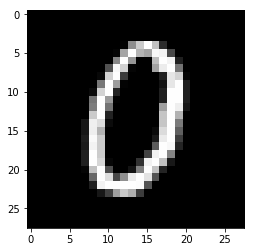

Label for the Image:  0


In [4]:
data_np = DigitDataset('train.csv', './data/', train=True)
print("Number of Training Images: ", len(data_np))
plt.imshow(data_np[5][0], cmap='gray')
plt.show()
print("Label for the Image: ", data_np[5][1])

### 1.3 Dataloader

With a correctly defined Dataset class, I can now use the Dataloader provided by PyTorch to form mini-batches. The Dataloader prepares mini-batches during iteration. By setting the correct number for num_workers (base on the memory) and make pin_memory to True, the Dataloader can make the training iteration a lot faster on GPU.

In [5]:
composed_transform = transforms.Compose([Regularize(), ToTensor()])
data_torch = DigitDataset('train.csv', './data/', train=True, transform=composed_transform)
dataloader = DataLoader(data_torch,
                       batch_size=4,
                       shuffle=True,
                       num_workers=4)
for i, data in enumerate(dataloader, 0):
    digits, labels = data
    # digits, labels = digits.to("cuda"), labels.to("cuda")
    print("Type of Digits: ", type(digits))
    print("Dimension of the Tensor: ", digits.shape)
    print("Type of Labels: ", type(labels))
    print("Dimension of the Tensor: ", labels.shape)
    if i == 0:
        break

Type of Digits:  <class 'torch.Tensor'>
Dimension of the Tensor:  torch.Size([4, 1, 28, 28])
Type of Labels:  <class 'torch.Tensor'>
Dimension of the Tensor:  torch.Size([4])


### 1.4 Training and Validation Data Split

Since I have to validate how good is the trained model, I have to split the data from Kaggle into a training set and a validation set. At the same time, I want the validation set has the same class distribution as in the training set. (I tried to find a PyTorch function to do this but failed. Thus, I have to write one by myself. ) To do so, I first defined a function to compute the class distribution of a dataset, which returns how many digits are in the data for each label.

In [6]:
def digits_per_class(dataset, indices):
    assert isinstance(dataset, DigitDataset)
    assert isinstance(indices, list)
    digit_num = [0 for num in range(10)]
    for idx in indices:
        digit_num[dataset[idx][1]] += 1
    return digit_num

Here, the function computed the class distribution of the data given by Kaggle.

In [7]:
digit_class_num = digits_per_class(data_torch,
                                  [num for num in range(len(data_torch))])
for i, num in enumerate(digit_class_num, 0):
    print("Number of Images for Digit ", i, ": ", num)
print("Overall Images: ", sum(digit_class_num))

Number of Images for Digit  0 :  4132
Number of Images for Digit  1 :  4684
Number of Images for Digit  2 :  4177
Number of Images for Digit  3 :  4351
Number of Images for Digit  4 :  4072
Number of Images for Digit  5 :  3795
Number of Images for Digit  6 :  4137
Number of Images for Digit  7 :  4401
Number of Images for Digit  8 :  4063
Number of Images for Digit  9 :  4188
Overall Images:  42000


Then, I defined a function to split the dataset into training and validation. The function returns two lists, representing the indices of the training set and the validation set, respectively. The code is relatively straightforward. I first get the class distribution of the complete dataset, then use it to compute the class distribution of the validation set based on the ratio provided to the user. Based on the validation class distribution, I put part of the data into the validation set.

In [8]:
def train_validate_split(dataset, test_ratio=0.2):
    assert isinstance(dataset, DigitDataset)
    overall_indices = [num for num in range(len(dataset))]
    overall_class_num = digits_per_class(dataset, overall_indices)
    test_class_num = [int(num*test_ratio) for num in overall_class_num]
    tmp_test_class_num = [0 for num in range(10)]
    shuffle(overall_indices)
    train_indices = []
    val_indices = []
    for idx in overall_indices:
        tmp_label = dataset[idx][1]
        if tmp_test_class_num[tmp_label] < test_class_num[tmp_label]:
            val_indices.append(idx)
            tmp_test_class_num[tmp_label] += 1
        else:
            train_indices.append(idx)
    return train_indices, val_indices

Here shows the class distribution of the validation set is proportional to the training set.

In [9]:
train_data, val_data = train_validate_split(data_torch)
train_class_num = digits_per_class(data_torch, train_data)
val_class_num = digits_per_class(data_torch, val_data)
for i, num in enumerate(train_class_num, 0):
    print("Number of Images for Digit ", i, "- Train: ", num, "Validate: ", val_class_num[i])
print("Train Images: ", sum(train_class_num), "Validate Images: ", sum(val_class_num))

Number of Images for Digit  0 - Train:  3306 Validate:  826
Number of Images for Digit  1 - Train:  3748 Validate:  936
Number of Images for Digit  2 - Train:  3342 Validate:  835
Number of Images for Digit  3 - Train:  3481 Validate:  870
Number of Images for Digit  4 - Train:  3258 Validate:  814
Number of Images for Digit  5 - Train:  3036 Validate:  759
Number of Images for Digit  6 - Train:  3310 Validate:  827
Number of Images for Digit  7 - Train:  3521 Validate:  880
Number of Images for Digit  8 - Train:  3251 Validate:  812
Number of Images for Digit  9 - Train:  3351 Validate:  837
Train Images:  33604 Validate Images:  8396


An easy way to use the generated index list is to use the sampler provided by PyTorch. By using the defined sampler in the Dataloader, the Dataloader will only prepare mini-batches from the data included in the sampler.

Now we have all the necessary things we need on Dataset and Dataloader for training the model.

In [10]:
train_sampler = sampler.SubsetRandomSampler(train_data)
train_dataloader = DataLoader(data_torch,
                              batch_size=4,
                              shuffle=False,
                              sampler=train_sampler,
                              num_workers=4)

## 2. Network

After some paper reading, I think the most natural network to start with is the LeNet-5 (If you want to read the paper, [Here is LeCun's LeNet-5 paper from 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)). Honestly, I am amazed by how much they already have back in 1998 that built the foundation of deep learning today.

This network can be tuned later to maximize the performance by,

1. Adding more convolutional filters.
2. Adding more convolutional layers.
3. Increasing the dimension of fully connected layers.
4. Adding batch normalization layers.
5. and many other techniques.

In [11]:
class BasicLeNet(nn.Module):
    """ Basic LeNet-5 as defined in LeCun's paper"""

    def __init__(self):
        super(BasicLeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        """
        Feedforward function

        :param x: input batch
        :return: x
        """
        x = self.features(x)
        x = x.view(x.size(0), 16*4*4)
        x = self.classifier(x)
        return x

## 3. Training (and Validation)

Now I want to define a training function that trains any network. The function first creates a training Dataloader and a validation Dataloader, and then it optimizes the network using mini-batches from the Dataloader using iterations.


In [12]:
def training(network, criterion, optimizer, epoch_num):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Start Training with", device, epoch_num, "overall epoch")
    network.to(device)
    """
    Create Dataloader for training and validating
    """
    composed_transform = transforms.Compose([Regularize(), ToTensor()])
    digit_dataset = DigitDataset('train.csv', './data/', train=True, transform=composed_transform)
    train_indices, val_indices = train_validate_split(digit_dataset)
    train_sampler = sampler.SubsetRandomSampler(train_indices)
    val_sampler = sampler.SubsetRandomSampler(val_indices)
    train_dataloader = DataLoader(
        digit_dataset,
        batch_size=32,
        shuffle=False,
        sampler=train_sampler,
        num_workers=4,
        pin_memory=True
    )
    val_dataloader = DataLoader(
        digit_dataset,
        batch_size=32,
        shuffle=False,
        sampler=val_sampler,
        num_workers=4,
        pin_memory=True
    )
    print("Training with validation, ", "Overall Data:", len(train_indices)+len(val_indices))
    print("Training Data:", len(train_indices), "Validate Data:", len(val_indices))
    """
    Start Training
    """
    batch_num = 0
    ita = []
    loss_avg = []
    val_acc = []
    for epoch in range(epoch_num):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            digits, labels = data
            digits, labels = digits.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = network(digits)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_num += 1
            if i % 500 == 499:
                ita.append(batch_num)
                loss_avg.append(running_loss/500.)
                val_acc.append(validating(network, val_dataloader))
                running_loss = 0.
    train_accuracy = validating(network, train_dataloader)
    val_accuracy = validating(network, val_dataloader)
    print('Training accuracy: %.5f' % (train_accuracy))
    print('Validation accuracy: %.5f' % (val_accuracy))
    return network, ita, loss_avg, val_acc

I also defined a validating function. The function efficiently generates the prediction accuracy of the network. I used this function to generate the training accuracy and validation accuracy after training.

In [13]:
def validating(network, loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    correct_num = 0
    total_num = 0
    for i, data in enumerate(loader, 0):
        digits, labels = data
        total_num += labels.size(0)
        digits, labels = digits.to(device), labels.to(device)
        outputs = network(digits)
        _, predicted = torch.max(outputs, 1)
        correct_num += ((predicted == labels).sum().to("cpu")).item()
    accuracy = correct_num / total_num
    return accuracy

Finally, I can train and test the network. Here I used the Cross-Entropy Loss function and Adam optimizer. After 30 epochs (with 80% of the training data given by Kaggle), the network has a validation accuracy of 98.8% with a converged loss function.

In [14]:
lenet = BasicLeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet.parameters())
lenet, batch_ita, loss_list, val_acc_list = training(lenet, criterion, optimizer, 30)

Start Training with cuda:0 30 overall epoch
Training with validation,  Overall Data: 42000
Training Data: 33604 Validate Data: 8396
Training accuracy: 0.99821
Validation accuracy: 0.98690


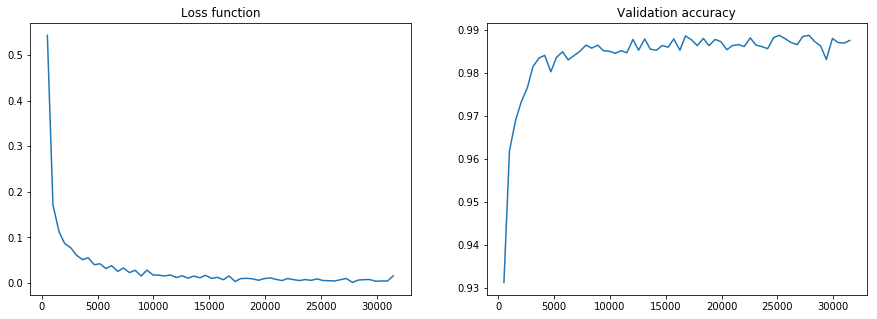

In [15]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(batch_ita, loss_list)
plt.title("Loss function")

plt.subplot(1, 2, 2)
plt.plot(batch_ita, val_acc_list)
plt.title("Validation accuracy")

plt.show()

This result using the LeNet-5 from 1998 is very good. To push it to state of the art around 99.6%, I still need to turn the network. To be continued ...

In [24]:
class LeNetMoreConvFilter(nn.Module):
    """ Basic LeNet-5 as defined in LeCun's paper"""

    def __init__(self):
        super(LeNetMoreConvFilter, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*4*4, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        """
        Feedforward function

        :param x: input batch
        :return: x
        """
        x = self.features(x)
        x = x.view(x.size(0), 64*4*4)
        x = self.classifier(x)
        return x

In [25]:
lenet2 = LeNetMoreConvFilter()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet2.parameters())
lenet2, batch_ita, loss_list, val_acc_list = training(lenet2, criterion, optimizer, 30)

Start Training with cuda:0 30 overall epoch
Training with validation,  Overall Data: 42000
Training Data: 33604 Validate Data: 8396
Training accuracy: 0.99976
Validation accuracy: 0.98988


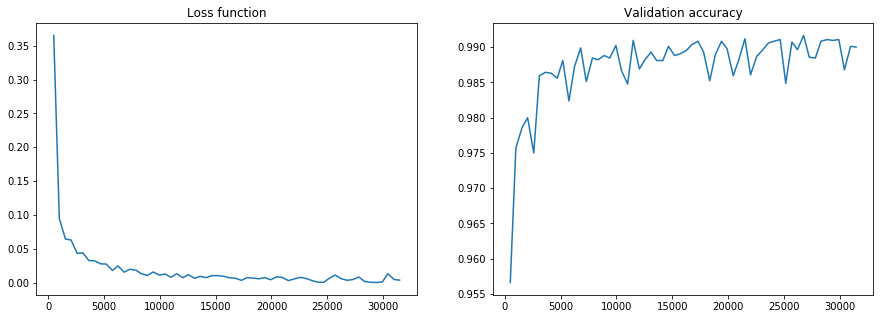

In [27]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(batch_ita, loss_list)
plt.title("Loss function")

plt.subplot(1, 2, 2)
plt.plot(batch_ita, val_acc_list)
plt.title("Validation accuracy")

plt.show()

In [38]:
class LeNetMoreConvFilter(nn.Module):
    """ Basic LeNet-5 as defined in LeCun's paper"""

    def __init__(self):
        super(LeNetMoreConvFilter, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        """
        Feedforward function

        :param x: input batch
        :return: x
        """
        x = self.features(x)
        x = x.view(x.size(0), 128*4*4)
        x = self.classifier(x)
        return x

In [39]:
lenet3 = LeNetMoreConvLayer()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet3.parameters())
lenet3, batch_ita, loss_list, val_acc_list = training(lenet3, criterion, optimizer, 30)

Start Training with cuda:0 30 overall epoch
Training with validation,  Overall Data: 42000
Training Data: 33604 Validate Data: 8396
Training accuracy: 0.99658
Validation accuracy: 0.98571
